# 0. Index:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

# 1. Importing your libraries and data

In [1]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'BAQYy-CQAyU7kz8UPz6s'

In [4]:
# Importing the Inflation Rates and the Consumer CPI for the Euro area variable.

data = quandl.get('RATEINF/CPI_EUR')

In [5]:
data.head(5)

,Value
Date,
1990-01-31,69.46
1990-02-28,69.71
1990-03-31,69.88
1990-04-30,70.14
1990-05-31,70.30


In [6]:
data.shape

(396, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

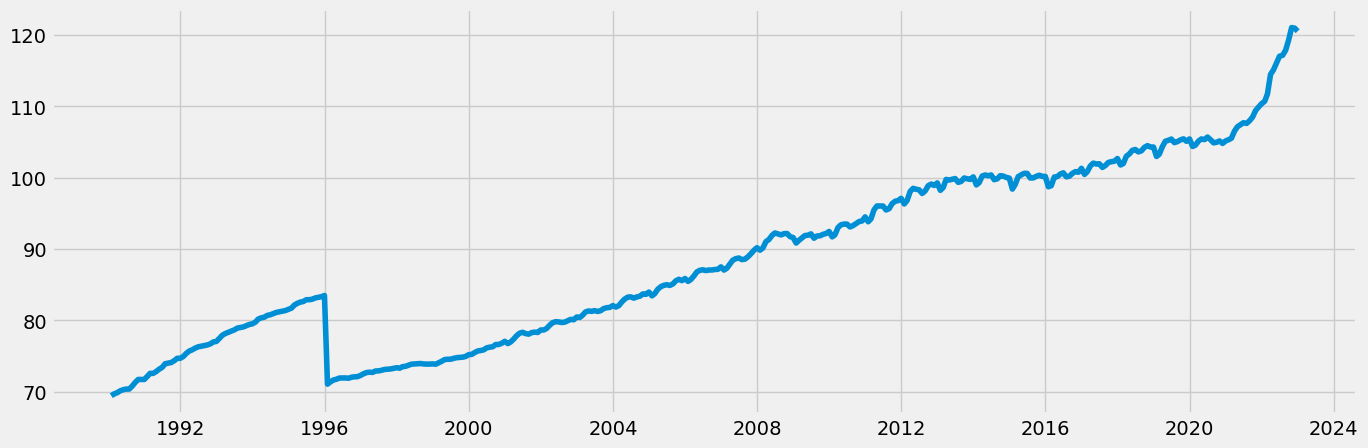

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1990-01-31,69.46
1,1990-02-28,69.71
2,1990-03-31,69.88
3,1990-04-30,70.14
4,1990-05-31,70.30


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2022-12-31')]

In [13]:
data_sub.shape

(275, 2)

In [14]:
data_sub.head()

,Date,Value
120,2000-01-31,75.25
121,2000-02-29,75.49
122,2000-03-31,75.72
123,2000-04-30,75.79
124,2000-05-31,75.88


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-31,75.25
2000-02-29,75.49
2000-03-31,75.72
2000-04-30,75.79
2000-05-31,75.88


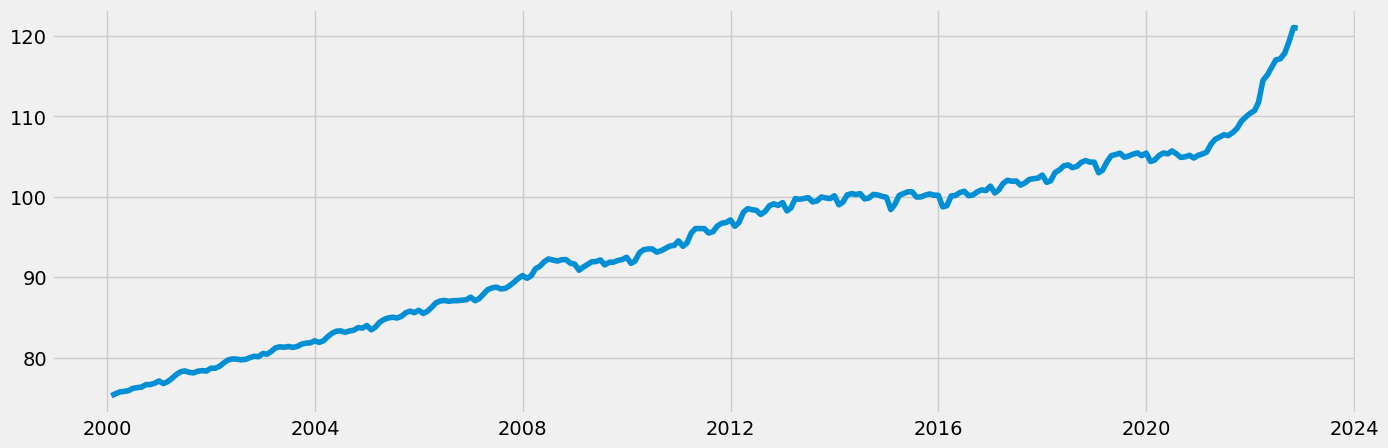

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

18

In [18]:
data_sub = data_sub.drop_duplicates()

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

In [20]:
data_sub.head()

,Value
datetime,
2000-01-31,75.25
2000-02-29,75.49
2000-03-31,75.72
2000-04-30,75.79
2000-05-31,75.88


# 3. Time-series analysis: decomposition

In [21]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = int(len(data_sub)/2))

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

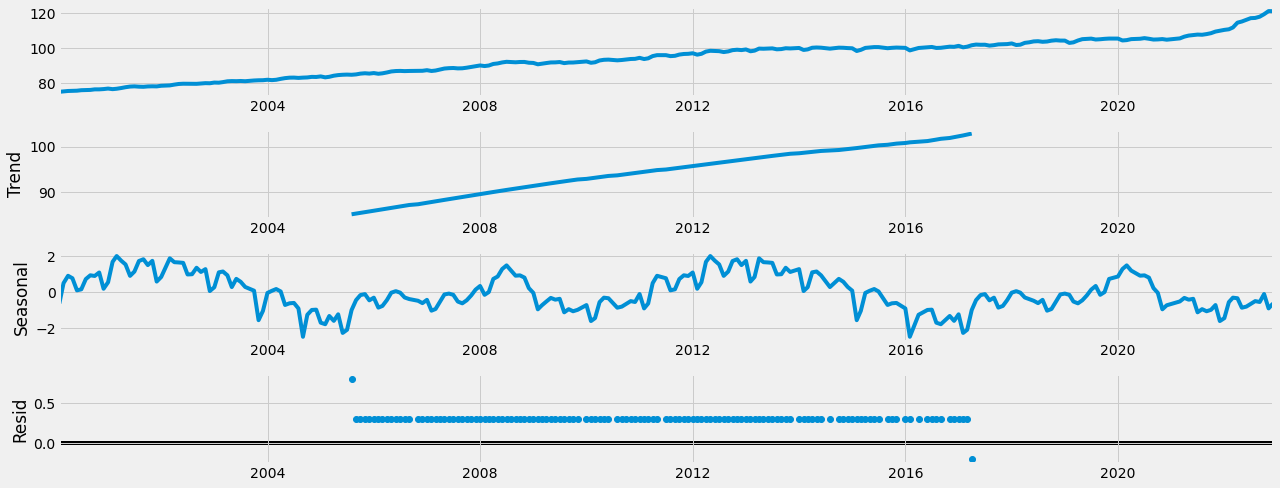

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

Analysis: The level and the trend line are similar. The trend line seems constant. There is seasonality but it's difficult to exmplain. There isn't noise (Residual line).

# 4. Testing for stationarity

In [24]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.363250
p-value                          0.996941
Number of Lags Used             12.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


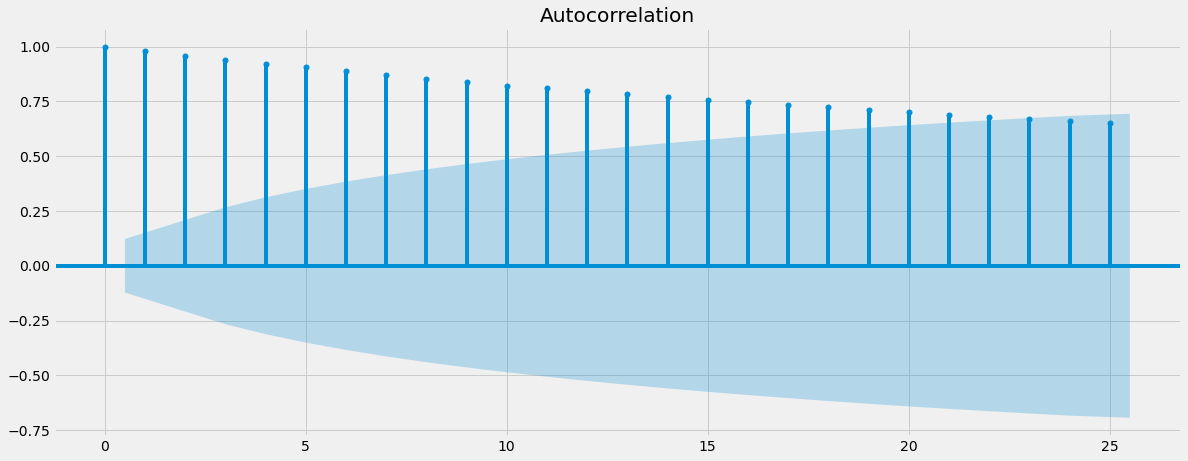

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#### Analysis

H0 = Presence of a unit root (non-stationary)
HA = Unit root present (stationary)

The test statistic of 1.363250 is larger than the critical value (5%) of -2.873459, meaning the null hypothesis cannot be rejected. The result is also not significant as the p-value is more than 0.05.

That means that there is a unit root in my data and it is non-stationariy.

The test shows that there are vertical lines that go above the blue edge of the confidence interval, indicating that the lags are significantly correlated with each other and the data is non-stationary.


# 5. Stationarizing the Inflation Rates in the Euro Area

In [26]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [27]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [28]:
data_diff.head()

,Value
datetime,
2000-02-29,0.24
2000-03-31,0.23
2000-04-30,0.07
2000-05-31,0.09
2000-06-30,0.28


In [29]:
data_diff.columns

Index(['Value'], dtype='object')

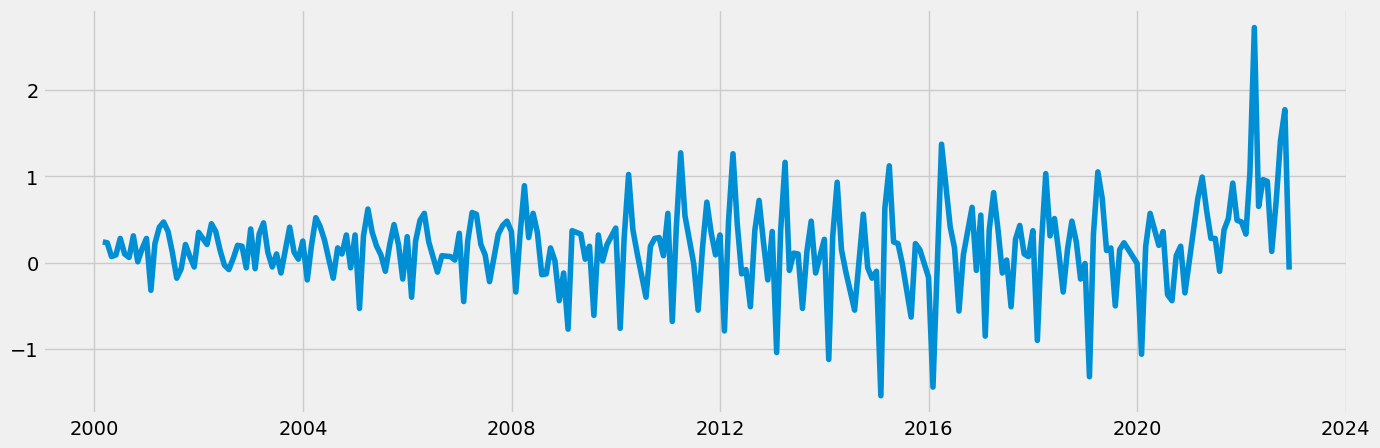

In [30]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [31]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                   0.253992
p-value                          0.975132
Number of Lags Used             11.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


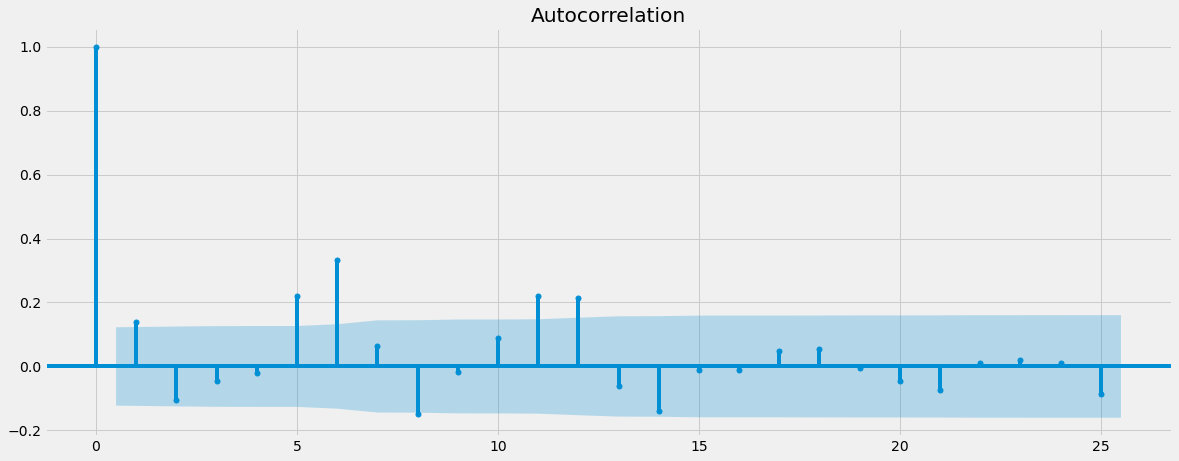

In [32]:
plot_acf(data_diff)
plt.show()

#### Analysis

H0 = Presence of a unit root (non-stationary)
HA = Unit root present (stationary)

The test statistic of 0.253992 is larger than the critical value (5%) of -2.873459, meaning the null hypothesis cannot be rejected. The result is also not significant as the p-value is more than 0.05.

That means that there is a unit root in my data and it is non-stationariy.

The test shows that there are vertical lines that go above the blue edge of the confidence interval, indicating that the lags are significantly correlated with each other and the data is non-stationary.

In [33]:
data_diff2 = data_diff- data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [34]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [54]:
data_diff2.head()

,Value
datetime,
2000-03-31,-0.01
2000-04-30,-0.16
2000-05-31,0.02
2000-06-30,0.19
2000-07-31,-0.18


In [55]:
data_diff2.columns

Index(['Value'], dtype='object')

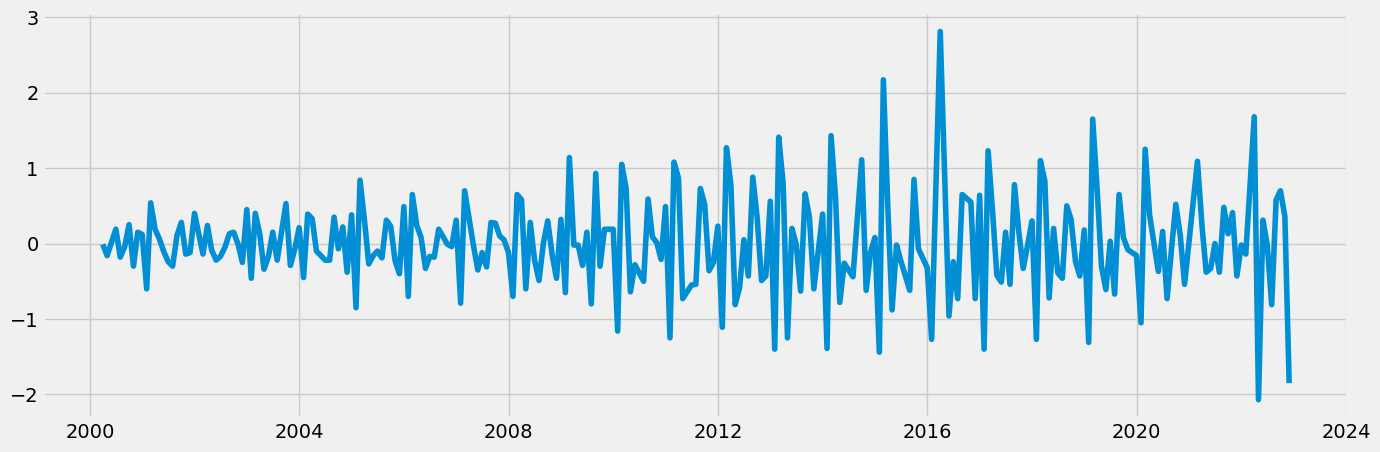

In [37]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [38]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.858411e+00
p-value                        4.297483e-17
Number of Lags Used            1.000000e+01
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


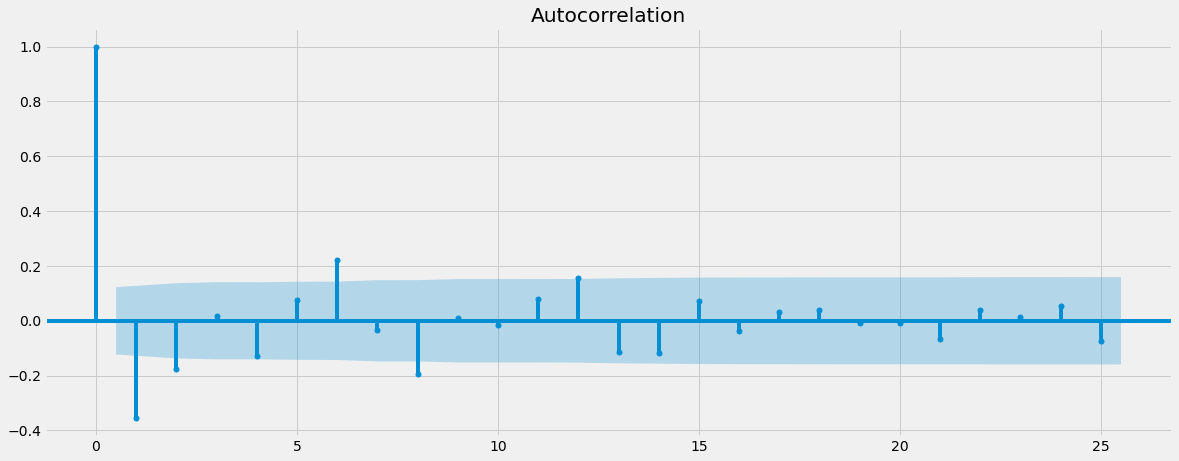

In [58]:
plot_acf(data_diff2)
plt.show()

#### Analysis

H0 = Presence of a unit root (non-stationary)
HA = Unit root present (stationary)

The test statistic of -9.858411e+00 is now smaller than the critical value (5%) of -2.873459e+00. However, the p-value is still bigger than 0.05 so even if the data now is stationary, the result is not significant.

The test shows that there are still vertical lines that go above the blue edge of the confidence interval, although many less. 

In [49]:
data_diff3 = data_diff2- data_diff2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [50]:
data_diff3.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [51]:
data_diff3.head()

,Value
datetime,
2000-02-29,0.24
2000-03-31,0.23
2000-04-30,0.07
2000-05-31,0.09
2000-06-30,0.28


In [53]:
data_diff3.columns

Index(['Value'], dtype='object')

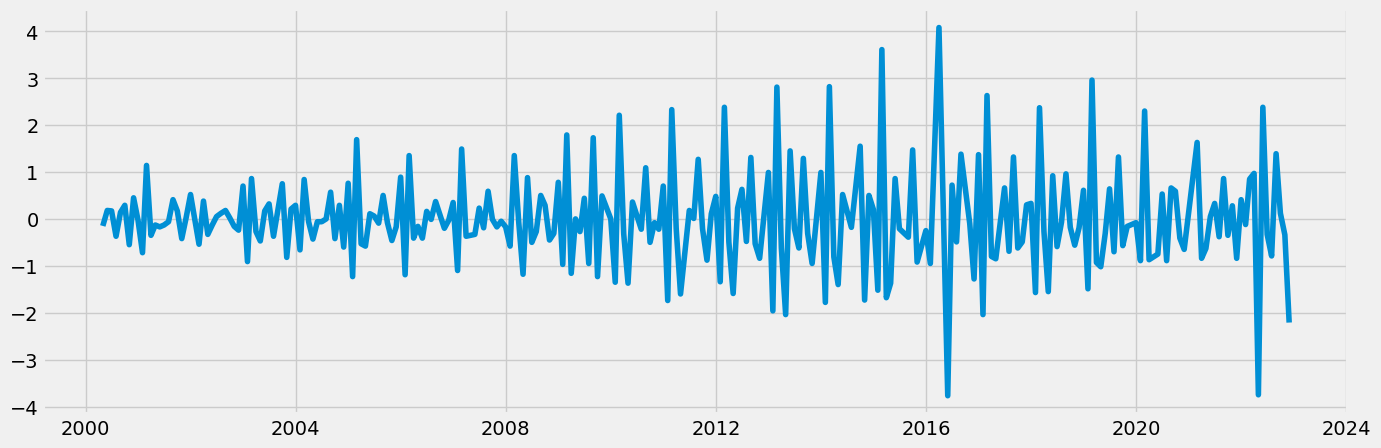

In [56]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

In [57]:
dickey_fuller(data_diff3)

Dickey-Fuller Stationarity test:
Test Statistic                -1.018851e+01
p-value                        6.413629e-18
Number of Lags Used            1.500000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


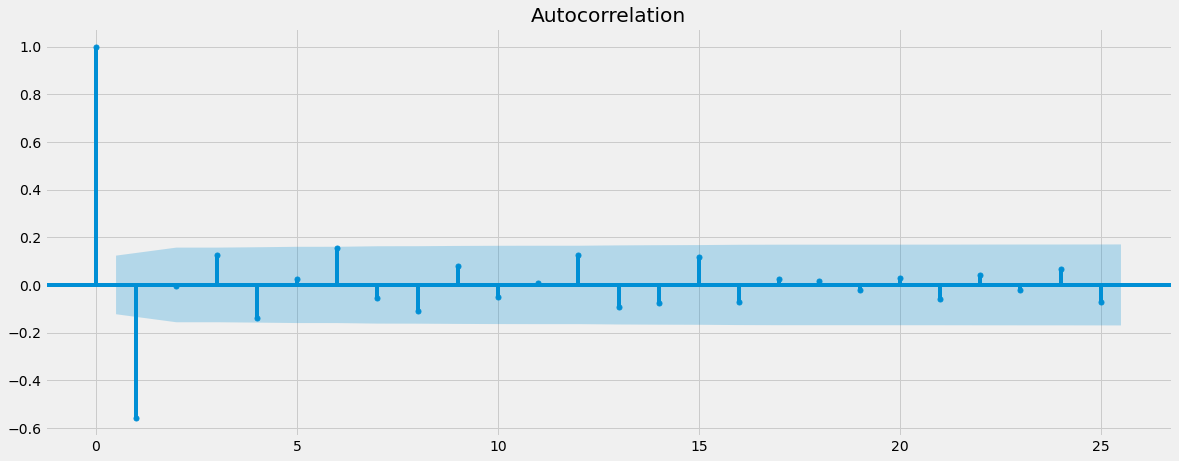

In [60]:
plot_acf(data_diff3)
plt.show()

#### Analysis

H0 = Presence of a unit root (non-stationary)
HA = Unit root present (stationary)

The test statistic of --1.018851e+01 is again bigger than the critical value (5%) of -2.873762e+00 and the the p-value is also bigger than 0.05.

The test shows that there are still vertical lines that go above the blue edge of the confidence interval, although many less. 